In [1]:
%load_ext autoreload
%autoreload 2

[INFO] 2025-03-26 16:20:30 - <fbpinns.constants.Constants object at 0x742d0a5374a0>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0., 0.]), 'xmax': array([1., 1.])}
problem: <class 'fbpinns.problems.HeatEquation1D'>
problem_init_kwargs: {'alpha': 1.0}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]), array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])], 'subdomain_ws': [array([0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222,
       0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222]), array([0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222,
       0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222])], 'unnorm': (

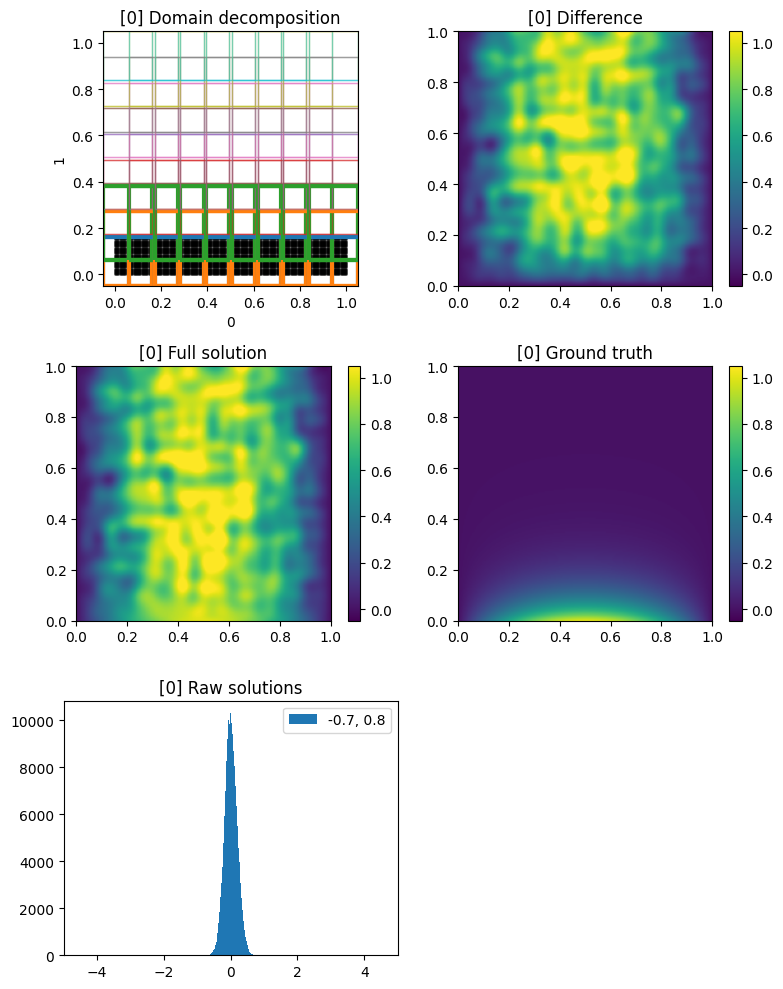

[INFO] 2025-03-26 16:20:41 - saved arrays
[INFO] 2025-03-26 16:20:41 - [i: 1000/100000] loss: 11.1851 rate: 212.5 elapsed: 0.00 hr test
[INFO] 2025-03-26 16:20:42 - [i: 2000/100000] loss: 0.8732 rate: 5058.4 elapsed: 0.00 hr test
[INFO] 2025-03-26 16:20:42 - [i: 3000/100000] loss: 0.2572 rate: 5070.2 elapsed: 0.00 hr test
[INFO] 2025-03-26 16:20:42 - [i: 4000/100000] loss: 0.1748 rate: 5113.2 elapsed: 0.00 hr test
[INFO] 2025-03-26 16:20:42 - [i: 5000/100000] loss: 0.1233 rate: 5249.3 elapsed: 0.00 hr test
True


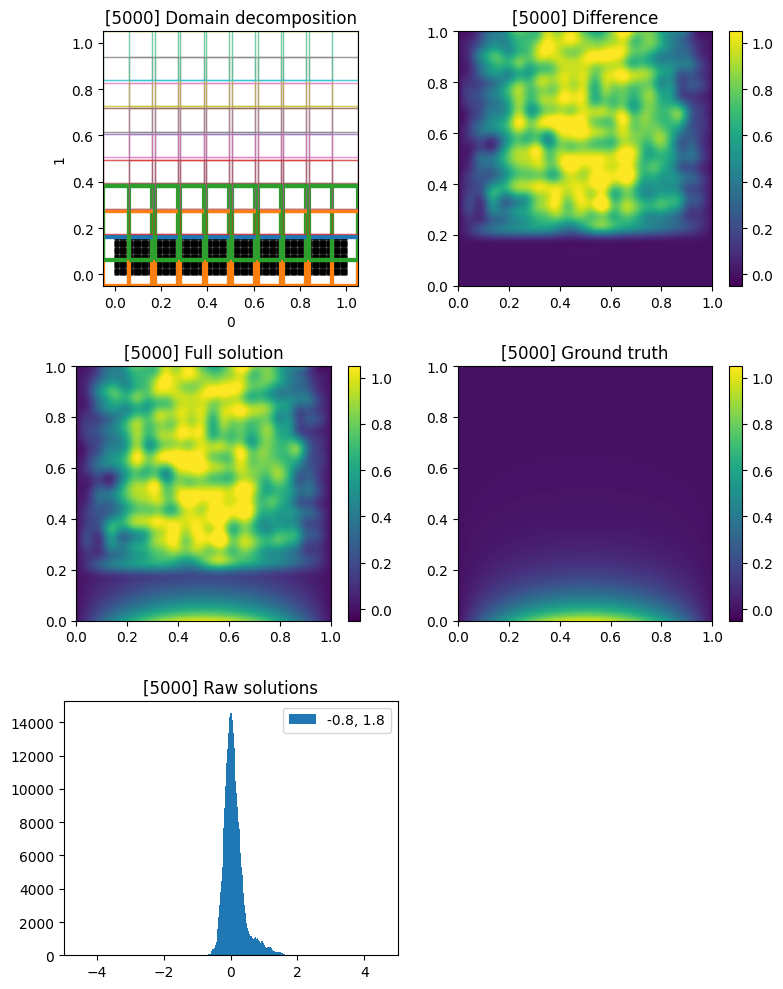

[INFO] 2025-03-26 16:20:43 - saved arrays
[INFO] 2025-03-26 16:20:43 - [i: 5264/100000] Updating active inputs..
[INFO] 2025-03-26 16:20:43 - [i: 5264/100000] Average number of points/dimension in active subdomains: 55.50
[INFO] 2025-03-26 16:20:46 - [i: 5264/100000] Updating active inputs done (2.52 s)
[INFO] 2025-03-26 16:20:46 - [i: 5264/100000] Compiling update step..
[INFO] 2025-03-26 16:20:46 - x_batch
[INFO] 2025-03-26 16:20:46 - (11000, 2), float32, JVPTracer
[INFO] 2025-03-26 16:20:46 - x_take
[INFO] 2025-03-26 16:20:46 - (84000, 2), float32, JVPTracer
[INFO] 2025-03-26 16:20:46 - x_batch
[INFO] 2025-03-26 16:20:46 - (11000, 2), float32, JVPTracer
[INFO] 2025-03-26 16:20:46 - x_take
[INFO] 2025-03-26 16:20:46 - (84000, 2), float32, JVPTracer
[INFO] 2025-03-26 16:20:48 - [i: 5264/100000] Compiling done (2.10 s)
[INFO] 2025-03-26 16:20:48 - [i: 6000/100000] loss: 0.6347 rate: 198.3 elapsed: 0.00 hr test
[INFO] 2025-03-26 16:20:49 - [i: 7000/100000] loss: 0.1228 rate: 2166.3 elap

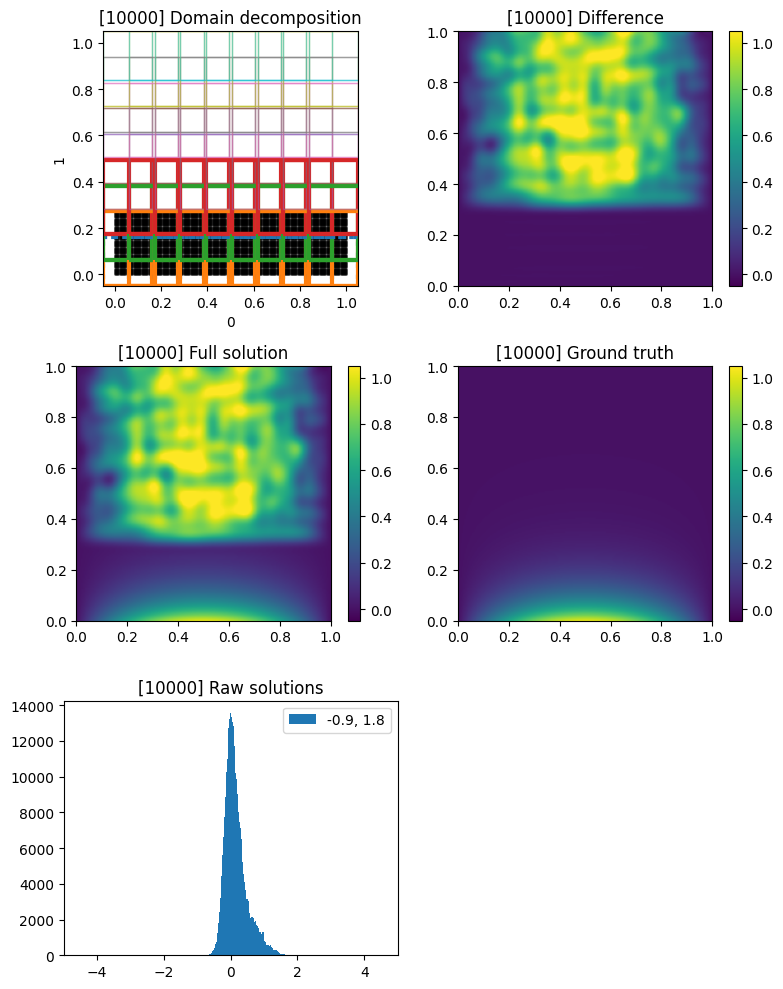

[INFO] 2025-03-26 16:20:51 - saved arrays
[INFO] 2025-03-26 16:20:52 - [i: 11000/100000] loss: 0.0776 rate: 1940.3 elapsed: 0.00 hr test
[INFO] 2025-03-26 16:20:52 - [i: 12000/100000] loss: 0.0559 rate: 1940.6 elapsed: 0.00 hr test
[INFO] 2025-03-26 16:20:53 - [i: 13000/100000] loss: 0.0365 rate: 1945.2 elapsed: 0.00 hr test
[INFO] 2025-03-26 16:20:53 - [i: 14000/100000] loss: 0.0406 rate: 1939.9 elapsed: 0.00 hr test
[INFO] 2025-03-26 16:20:54 - [i: 15000/100000] loss: 0.0290 rate: 1940.3 elapsed: 0.01 hr test
True


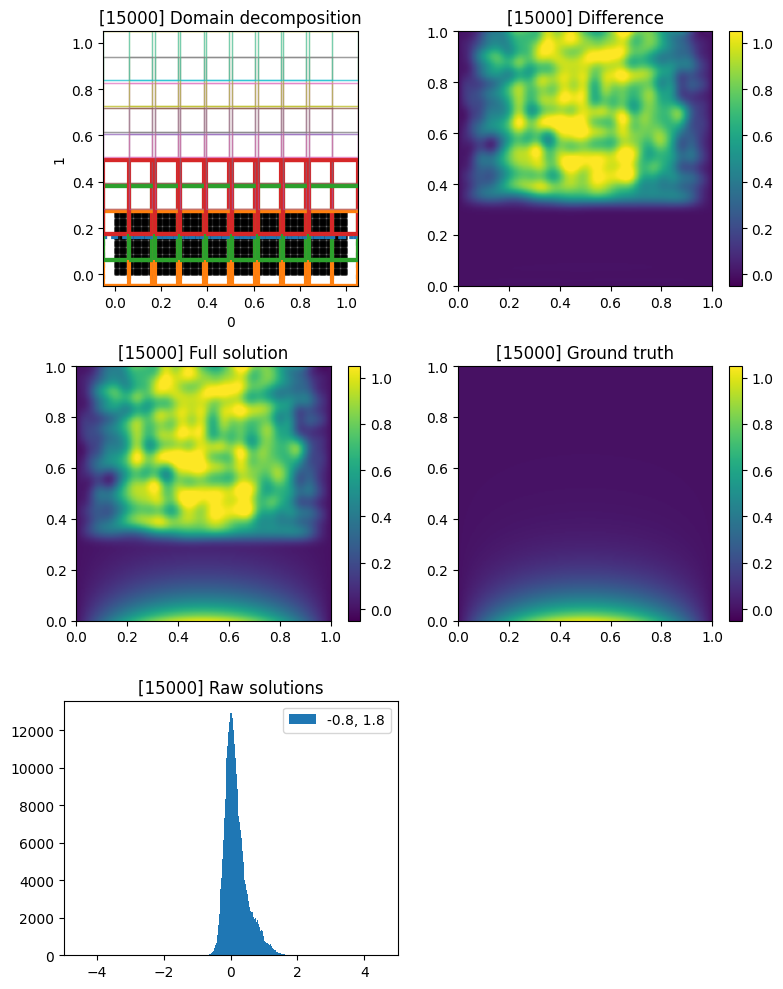

[INFO] 2025-03-26 16:20:55 - saved arrays
[INFO] 2025-03-26 16:20:55 - [i: 15790/100000] Updating active inputs..
[INFO] 2025-03-26 16:20:55 - [i: 15790/100000] Average number of points/dimension in active subdomains: 59.87
[INFO] 2025-03-26 16:20:58 - [i: 15790/100000] Updating active inputs done (2.62 s)
[INFO] 2025-03-26 16:20:58 - [i: 15790/100000] Compiling update step..
[INFO] 2025-03-26 16:20:58 - x_batch
[INFO] 2025-03-26 16:20:58 - (12800, 2), float32, JVPTracer
[INFO] 2025-03-26 16:20:58 - x_take
[INFO] 2025-03-26 16:20:58 - (105280, 2), float32, JVPTracer
[INFO] 2025-03-26 16:20:58 - x_batch
[INFO] 2025-03-26 16:20:58 - (12800, 2), float32, JVPTracer
[INFO] 2025-03-26 16:20:58 - x_take
[INFO] 2025-03-26 16:20:58 - (105280, 2), float32, JVPTracer
[INFO] 2025-03-26 16:21:00 - [i: 15790/100000] Compiling done (2.02 s)
[INFO] 2025-03-26 16:21:00 - [i: 16000/100000] loss: 1.6883 rate: 193.1 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:01 - [i: 17000/100000] loss: 0.0766 rate: 15

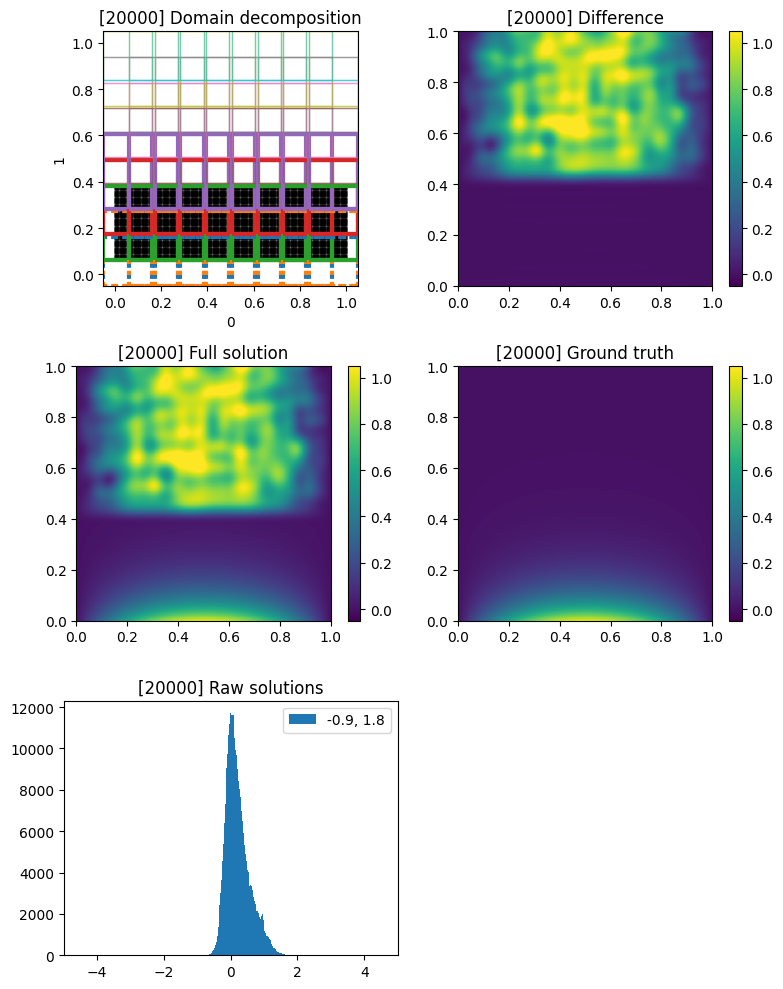

[INFO] 2025-03-26 16:21:03 - saved arrays
[INFO] 2025-03-26 16:21:04 - [i: 21000/100000] loss: 0.0460 rate: 1444.6 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:05 - [i: 22000/100000] loss: 0.0519 rate: 1444.0 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:06 - [i: 23000/100000] loss: 0.0684 rate: 1440.3 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:06 - [i: 24000/100000] loss: 0.0613 rate: 1441.3 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:07 - [i: 25000/100000] loss: 0.0204 rate: 1444.4 elapsed: 0.01 hr test
True


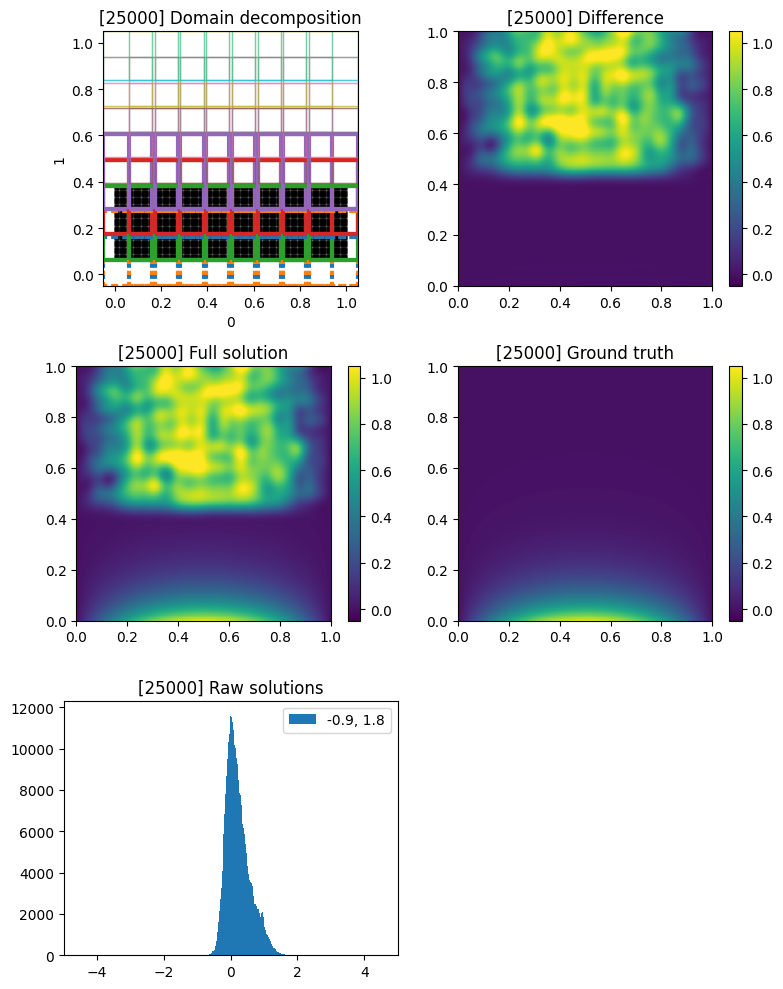

[INFO] 2025-03-26 16:21:08 - saved arrays
[INFO] 2025-03-26 16:21:09 - [i: 26000/100000] loss: 0.0183 rate: 1445.3 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:09 - [i: 26316/100000] Updating active inputs..
[INFO] 2025-03-26 16:21:09 - [i: 26316/100000] Average number of points/dimension in active subdomains: 59.87
[INFO] 2025-03-26 16:21:09 - [i: 26316/100000] Updating active inputs done (0.20 s)
[INFO] 2025-03-26 16:21:09 - [i: 26316/100000] Compiling update step..
[INFO] 2025-03-26 16:21:09 - [i: 26316/100000] Compiling done (0.03 s)
[INFO] 2025-03-26 16:21:10 - [i: 27000/100000] loss: 0.5144 rate: 1088.5 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:10 - [i: 28000/100000] loss: 0.0700 rate: 1443.5 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:11 - [i: 29000/100000] loss: 0.0824 rate: 1442.8 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:12 - [i: 30000/100000] loss: 0.0406 rate: 1444.2 elapsed: 0.01 hr test
True


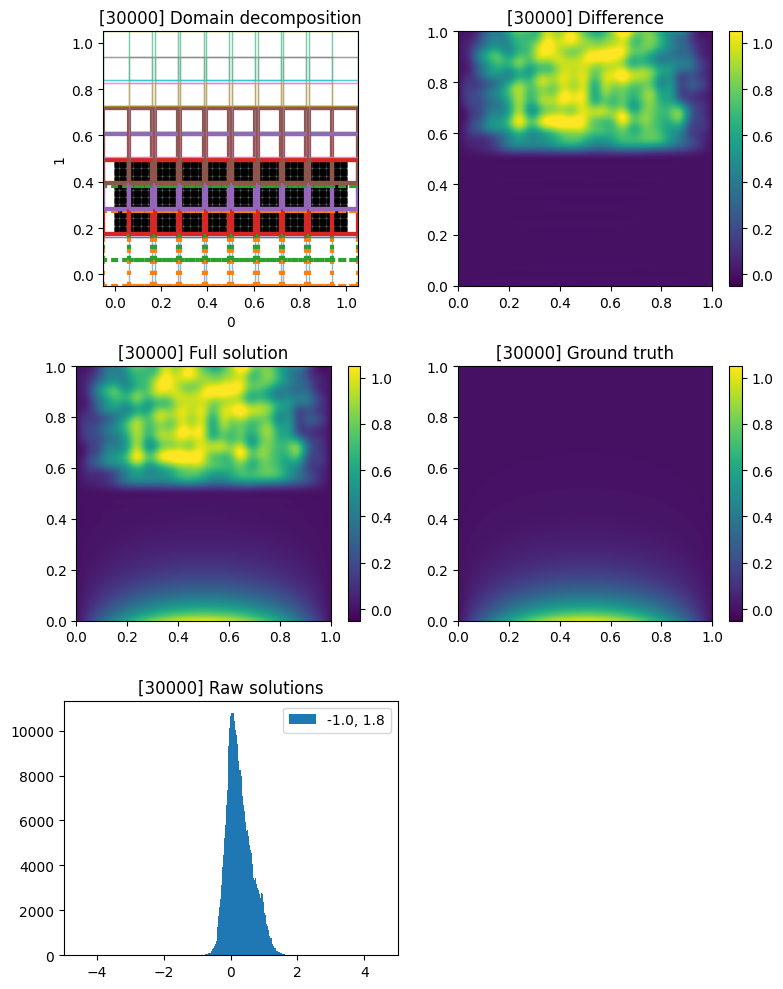

[INFO] 2025-03-26 16:21:13 - saved arrays
[INFO] 2025-03-26 16:21:13 - [i: 31000/100000] loss: 0.0306 rate: 1442.4 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:14 - [i: 32000/100000] loss: 0.2581 rate: 1440.8 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:15 - [i: 33000/100000] loss: 0.0486 rate: 1442.9 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:15 - [i: 34000/100000] loss: 0.1429 rate: 1442.1 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:16 - [i: 35000/100000] loss: 0.0237 rate: 1443.4 elapsed: 0.01 hr test
True


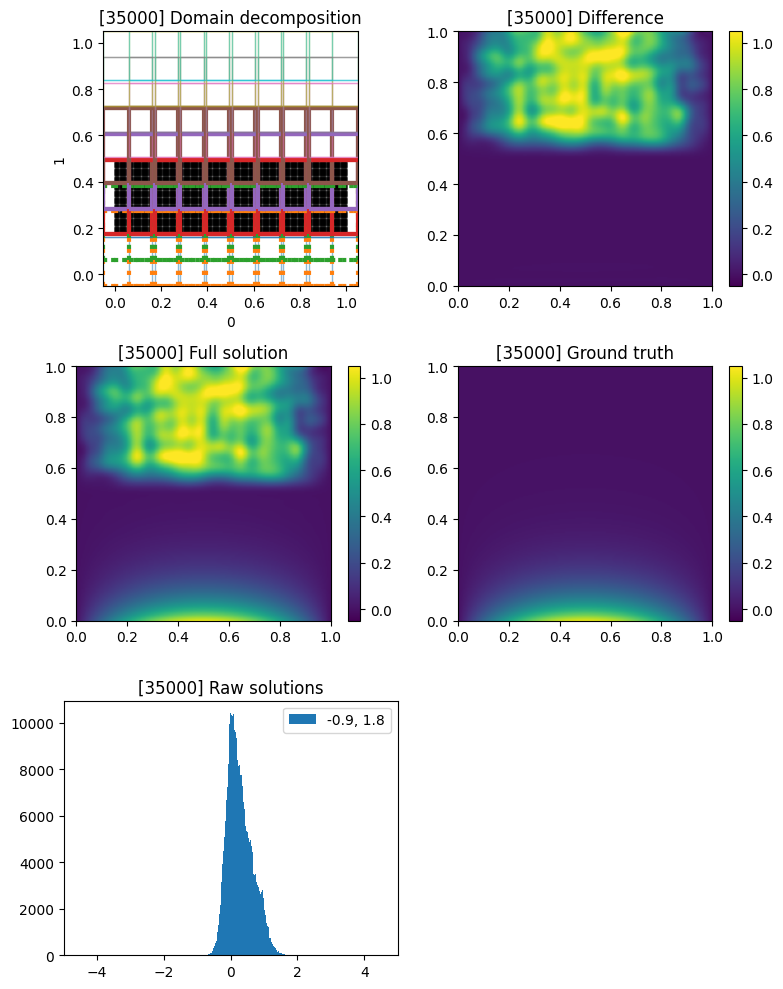

[INFO] 2025-03-26 16:21:17 - saved arrays
[INFO] 2025-03-26 16:21:18 - [i: 36000/100000] loss: 0.0211 rate: 1442.3 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:18 - [i: 36843/100000] Updating active inputs..
[INFO] 2025-03-26 16:21:18 - [i: 36843/100000] Average number of points/dimension in active subdomains: 59.87
[INFO] 2025-03-26 16:21:18 - [i: 36843/100000] Updating active inputs done (0.04 s)
[INFO] 2025-03-26 16:21:18 - [i: 36843/100000] Compiling update step..
[INFO] 2025-03-26 16:21:18 - [i: 36843/100000] Compiling done (0.03 s)
[INFO] 2025-03-26 16:21:18 - [i: 37000/100000] loss: 4.4533 rate: 1324.2 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:19 - [i: 38000/100000] loss: 0.1016 rate: 1443.3 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:20 - [i: 39000/100000] loss: 0.0749 rate: 1441.6 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:21 - [i: 40000/100000] loss: 0.1042 rate: 1440.3 elapsed: 0.01 hr test
True


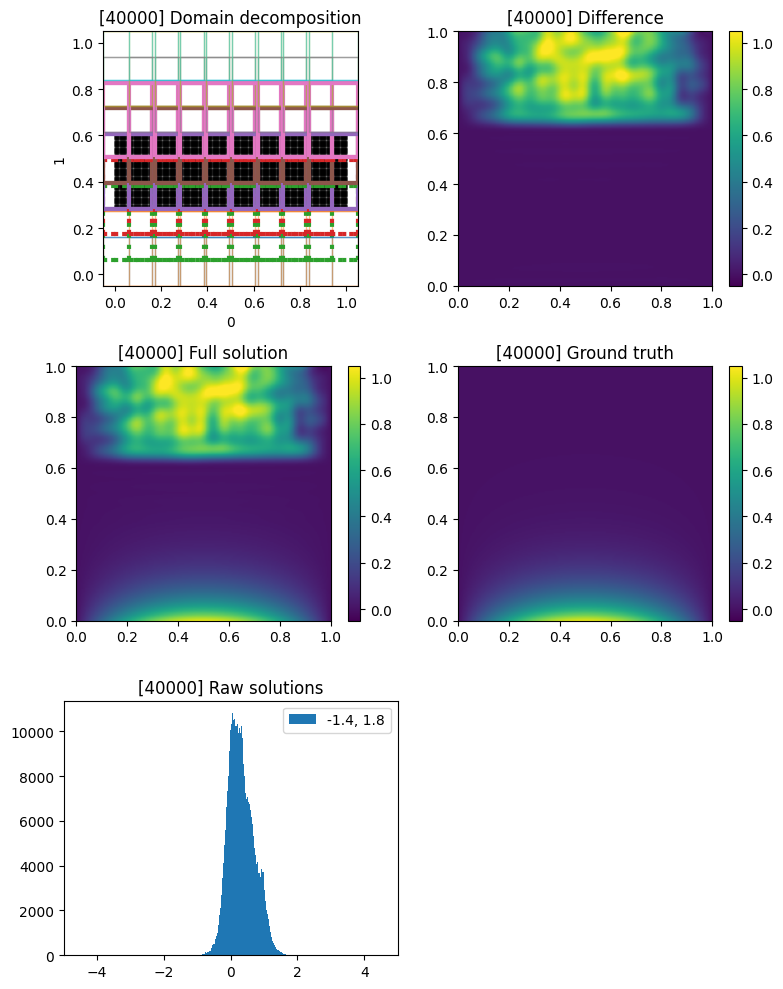

[INFO] 2025-03-26 16:21:21 - saved arrays
[INFO] 2025-03-26 16:21:22 - [i: 41000/100000] loss: 0.0408 rate: 1439.7 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:23 - [i: 42000/100000] loss: 0.0404 rate: 1439.6 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:23 - [i: 43000/100000] loss: 0.0299 rate: 1442.6 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:24 - [i: 44000/100000] loss: 0.0234 rate: 1439.7 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:25 - [i: 45000/100000] loss: 0.0182 rate: 1440.1 elapsed: 0.01 hr test
True


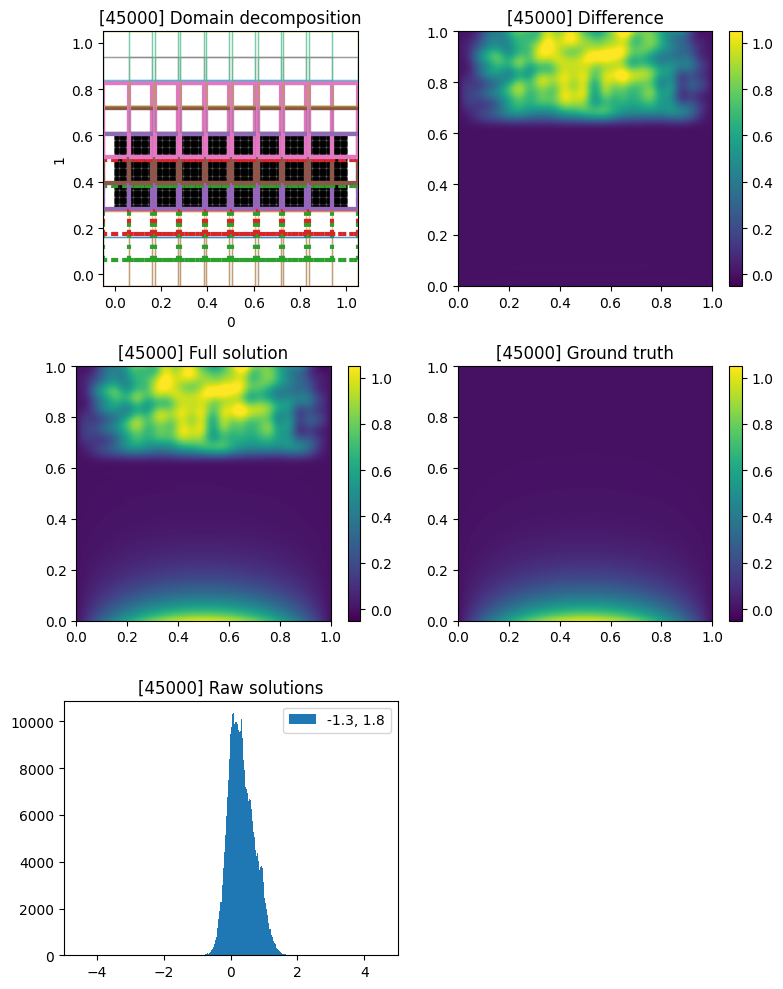

[INFO] 2025-03-26 16:21:26 - saved arrays
[INFO] 2025-03-26 16:21:26 - [i: 46000/100000] loss: 0.0241 rate: 1440.7 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:27 - [i: 47000/100000] loss: 0.0214 rate: 1442.4 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:27 - [i: 47369/100000] Updating active inputs..
[INFO] 2025-03-26 16:21:27 - [i: 47369/100000] Average number of points/dimension in active subdomains: 59.87
[INFO] 2025-03-26 16:21:27 - [i: 47369/100000] Updating active inputs done (0.05 s)
[INFO] 2025-03-26 16:21:27 - [i: 47369/100000] Compiling update step..
[INFO] 2025-03-26 16:21:27 - [i: 47369/100000] Compiling done (0.02 s)
[INFO] 2025-03-26 16:21:28 - [i: 48000/100000] loss: 0.1907 rate: 1315.5 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:29 - [i: 49000/100000] loss: 0.0554 rate: 1441.7 elapsed: 0.01 hr test
[INFO] 2025-03-26 16:21:29 - [i: 50000/100000] loss: 0.0828 rate: 1440.1 elapsed: 0.02 hr test
True


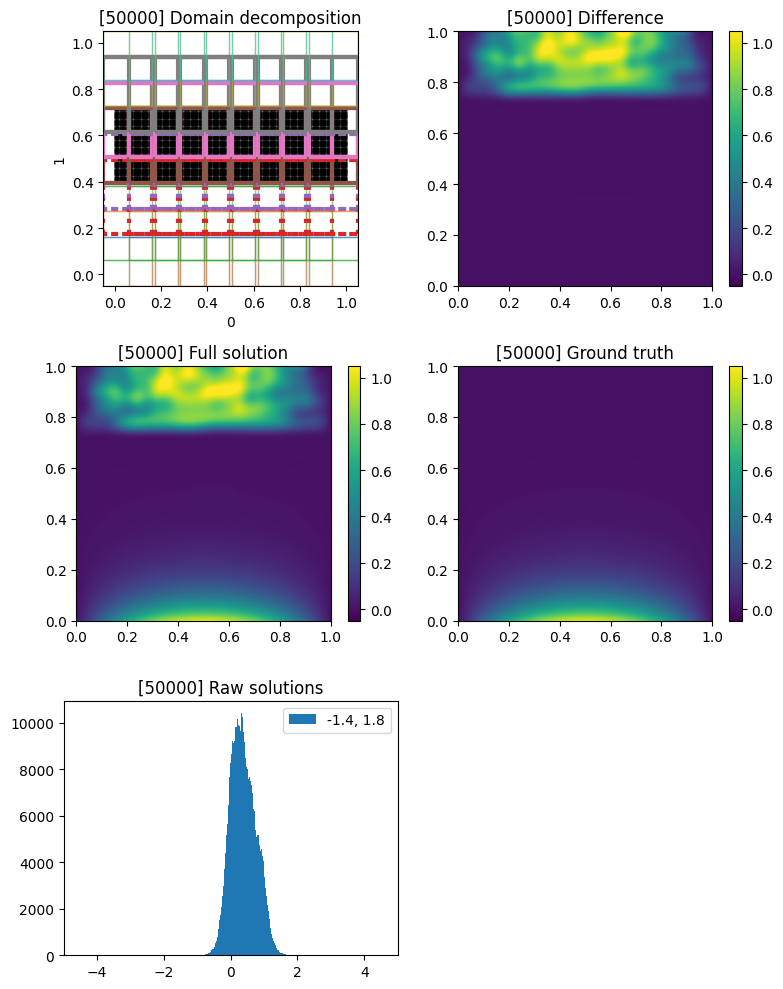

[INFO] 2025-03-26 16:21:30 - saved arrays
[INFO] 2025-03-26 16:21:31 - [i: 51000/100000] loss: 0.1493 rate: 1439.2 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:32 - [i: 52000/100000] loss: 0.0516 rate: 1438.4 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:32 - [i: 53000/100000] loss: 0.0424 rate: 1442.7 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:33 - [i: 54000/100000] loss: 0.0501 rate: 1439.4 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:34 - [i: 55000/100000] loss: 0.1881 rate: 1439.3 elapsed: 0.02 hr test
True


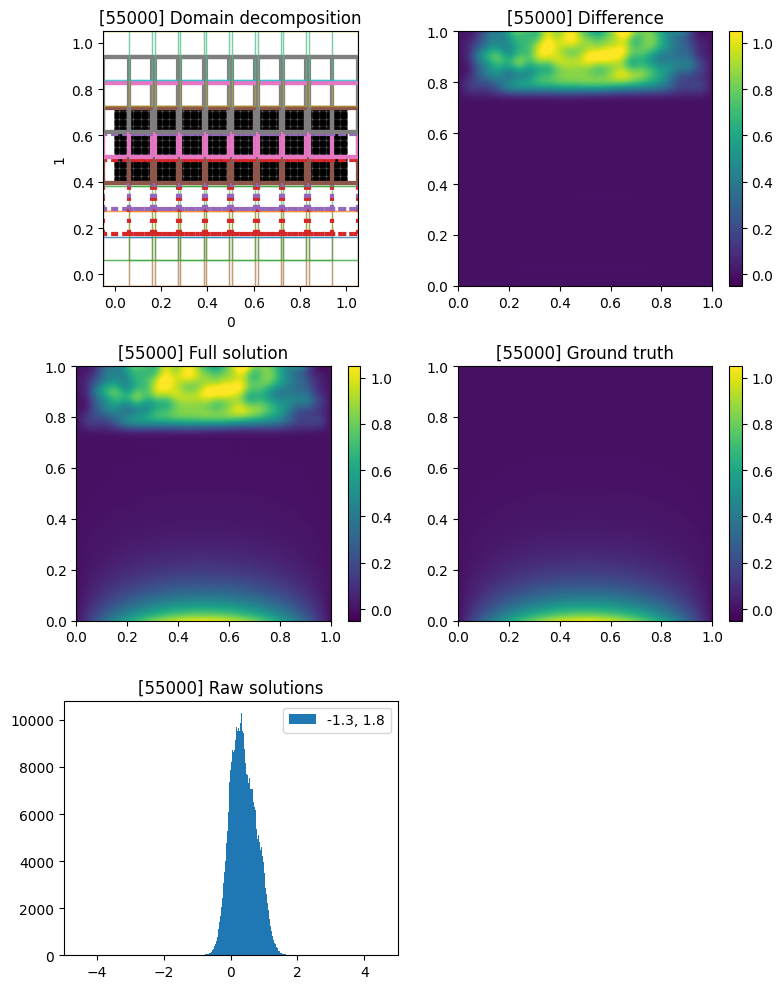

[INFO] 2025-03-26 16:21:35 - saved arrays
[INFO] 2025-03-26 16:21:35 - [i: 56000/100000] loss: 0.0160 rate: 1438.6 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:36 - [i: 57000/100000] loss: 0.0699 rate: 1441.0 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:37 - [i: 57895/100000] Updating active inputs..
[INFO] 2025-03-26 16:21:37 - [i: 57895/100000] Average number of points/dimension in active subdomains: 59.87
[INFO] 2025-03-26 16:21:37 - [i: 57895/100000] Updating active inputs done (0.05 s)
[INFO] 2025-03-26 16:21:37 - [i: 57895/100000] Compiling update step..
[INFO] 2025-03-26 16:21:37 - [i: 57895/100000] Compiling done (0.03 s)
[INFO] 2025-03-26 16:21:37 - [i: 58000/100000] loss: 3.0122 rate: 1312.2 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:38 - [i: 59000/100000] loss: 0.0541 rate: 1444.1 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:38 - [i: 60000/100000] loss: 0.0392 rate: 1443.7 elapsed: 0.02 hr test
True


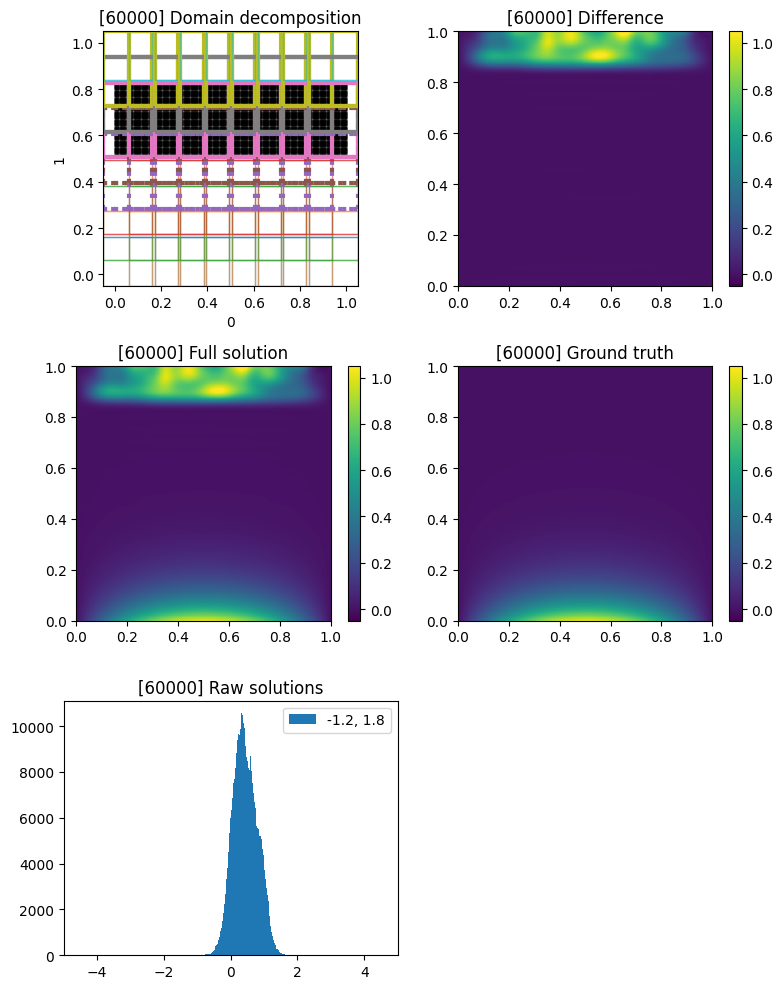

[INFO] 2025-03-26 16:21:39 - saved arrays
[INFO] 2025-03-26 16:21:40 - [i: 61000/100000] loss: 0.0308 rate: 1442.8 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:40 - [i: 62000/100000] loss: 0.0256 rate: 1445.3 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:41 - [i: 63000/100000] loss: 0.0209 rate: 1444.8 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:42 - [i: 64000/100000] loss: 0.0176 rate: 1444.9 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:43 - [i: 65000/100000] loss: 0.0367 rate: 1444.5 elapsed: 0.02 hr test
True


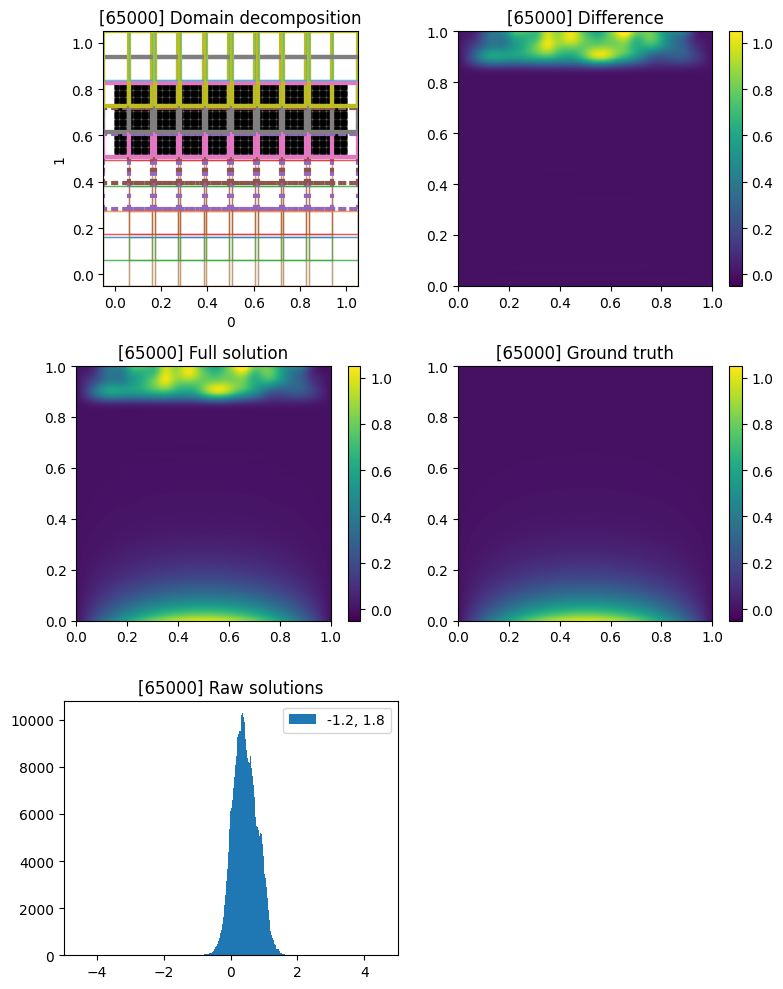

[INFO] 2025-03-26 16:21:43 - saved arrays
[INFO] 2025-03-26 16:21:44 - [i: 66000/100000] loss: 0.0319 rate: 1443.2 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:45 - [i: 67000/100000] loss: 0.0370 rate: 1444.5 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:45 - [i: 68000/100000] loss: 0.0118 rate: 1445.4 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:46 - [i: 68422/100000] Updating active inputs..
[INFO] 2025-03-26 16:21:46 - [i: 68422/100000] Average number of points/dimension in active subdomains: 59.87
[INFO] 2025-03-26 16:21:46 - [i: 68422/100000] Updating active inputs done (0.11 s)
[INFO] 2025-03-26 16:21:46 - [i: 68422/100000] Compiling update step..
[INFO] 2025-03-26 16:21:46 - [i: 68422/100000] Compiling done (0.03 s)
[INFO] 2025-03-26 16:21:46 - [i: 69000/100000] loss: 1.2117 rate: 1211.8 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:47 - [i: 70000/100000] loss: 0.0689 rate: 1441.0 elapsed: 0.02 hr test
True


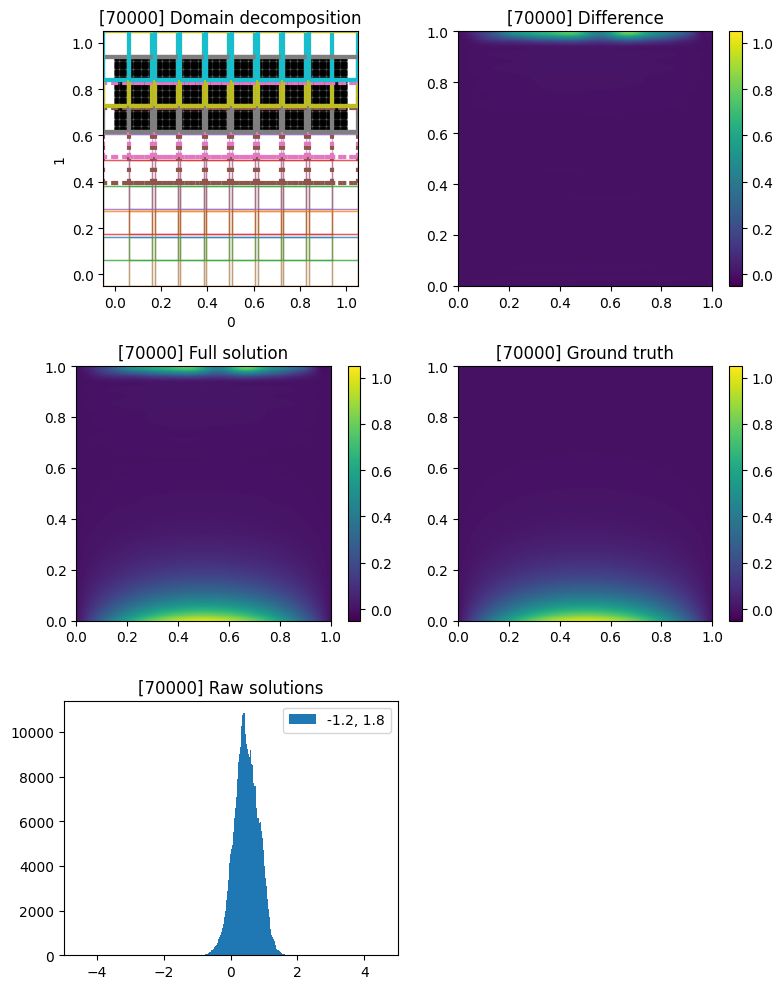

[INFO] 2025-03-26 16:21:48 - saved arrays
[INFO] 2025-03-26 16:21:48 - [i: 71000/100000] loss: 0.0496 rate: 1442.5 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:49 - [i: 72000/100000] loss: 0.0416 rate: 1439.6 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:50 - [i: 73000/100000] loss: 0.0351 rate: 1442.4 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:51 - [i: 74000/100000] loss: 0.0311 rate: 1443.7 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:51 - [i: 75000/100000] loss: 0.1028 rate: 1441.2 elapsed: 0.02 hr test
True


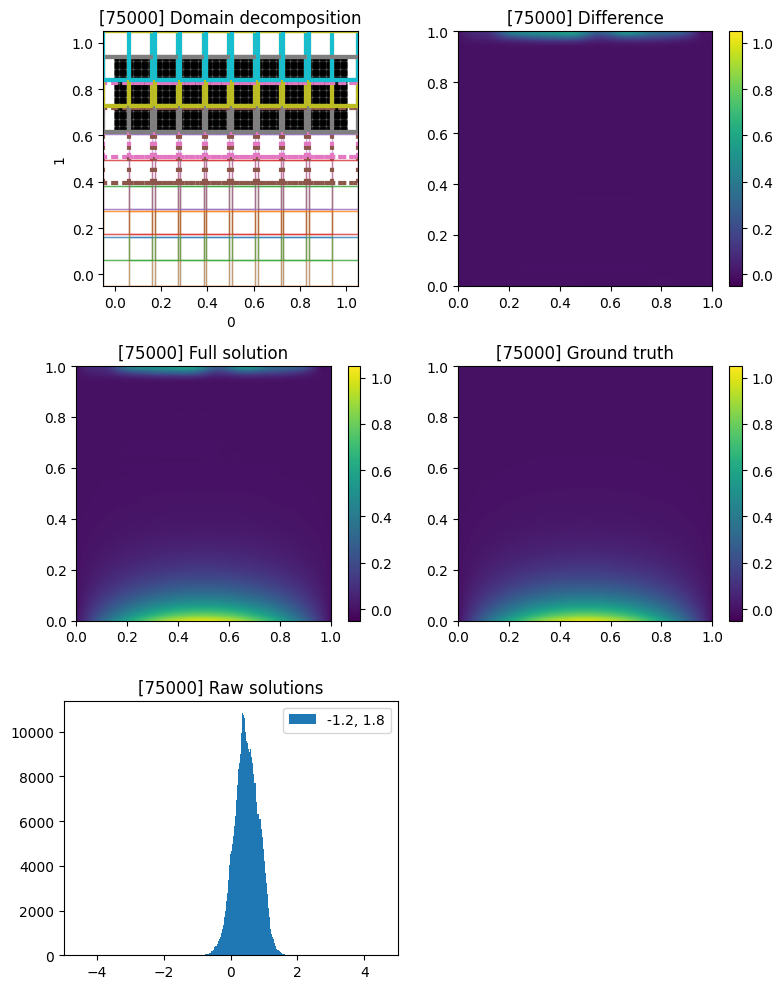

[INFO] 2025-03-26 16:21:52 - saved arrays
[INFO] 2025-03-26 16:21:53 - [i: 76000/100000] loss: 0.0622 rate: 1439.7 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:54 - [i: 77000/100000] loss: 0.0195 rate: 1443.1 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:54 - [i: 78000/100000] loss: 0.0277 rate: 1443.6 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:21:55 - [i: 78948/100000] Updating active inputs..
[INFO] 2025-03-26 16:21:55 - [i: 78948/100000] Average number of points/dimension in active subdomains: 55.50
[INFO] 2025-03-26 16:21:55 - [i: 78948/100000] Updating active inputs done (0.13 s)
[INFO] 2025-03-26 16:21:55 - [i: 78948/100000] Compiling update step..
[INFO] 2025-03-26 16:21:55 - x_batch
[INFO] 2025-03-26 16:21:55 - (11000, 2), float32, JVPTracer
[INFO] 2025-03-26 16:21:55 - x_take
[INFO] 2025-03-26 16:21:55 - (84000, 2), float32, JVPTracer
[INFO] 2025-03-26 16:21:55 - x_batch
[INFO] 2025-03-26 16:21:55 - (11000, 2), float32, JVPTracer
[INFO] 2025-03-26 16:21:55 - x_take
[INFO] 202

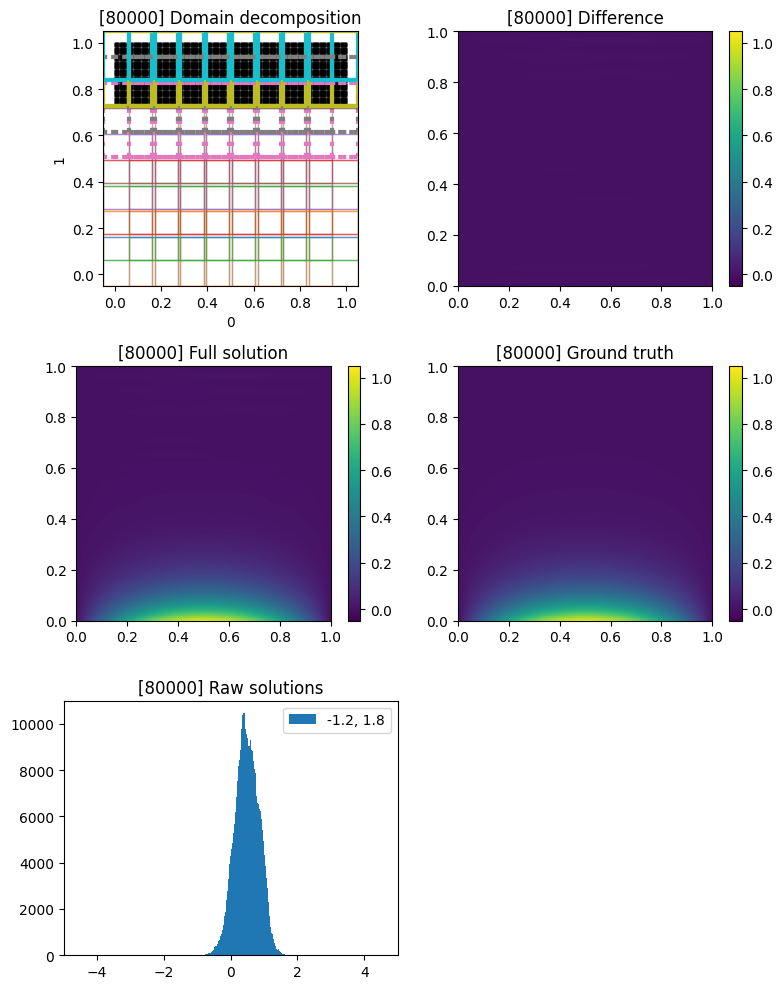

[INFO] 2025-03-26 16:21:58 - saved arrays
[INFO] 2025-03-26 16:21:59 - [i: 81000/100000] loss: 0.0465 rate: 1863.4 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:22:00 - [i: 82000/100000] loss: 0.0341 rate: 1858.3 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:22:00 - [i: 83000/100000] loss: 0.0290 rate: 1862.6 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:22:01 - [i: 84000/100000] loss: 0.0253 rate: 1861.3 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:22:01 - [i: 85000/100000] loss: 0.1636 rate: 1863.3 elapsed: 0.02 hr test
True


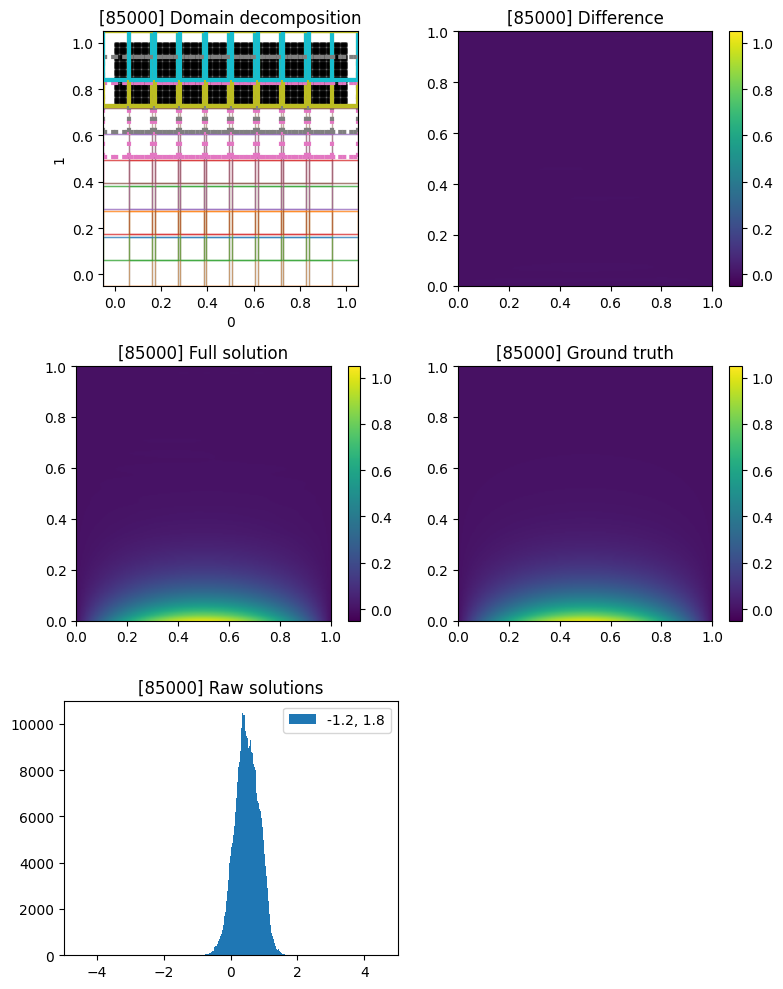

[INFO] 2025-03-26 16:22:02 - saved arrays
[INFO] 2025-03-26 16:22:03 - [i: 86000/100000] loss: 0.0173 rate: 1861.2 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:22:03 - [i: 87000/100000] loss: 0.0209 rate: 1861.9 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:22:04 - [i: 88000/100000] loss: 0.1274 rate: 1860.5 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:22:04 - [i: 89000/100000] loss: 0.0146 rate: 1863.1 elapsed: 0.02 hr test
[INFO] 2025-03-26 16:22:05 - [i: 89474/100000] Updating active inputs..
[INFO] 2025-03-26 16:22:05 - [i: 89474/100000] Average number of points/dimension in active subdomains: 42.99
[INFO] 2025-03-26 16:22:05 - [i: 89474/100000] Updating active inputs done (0.07 s)
[INFO] 2025-03-26 16:22:05 - [i: 89474/100000] Compiling update step..
[INFO] 2025-03-26 16:22:05 - x_batch
[INFO] 2025-03-26 16:22:05 - (6600, 2), float32, JVPTracer
[INFO] 2025-03-26 16:22:05 - x_take
[INFO] 2025-03-26 16:22:05 - (48160, 2), float32, JVPTracer
[INFO] 2025-03-26 16:22:05 - x_batch
[INFO] 2025-

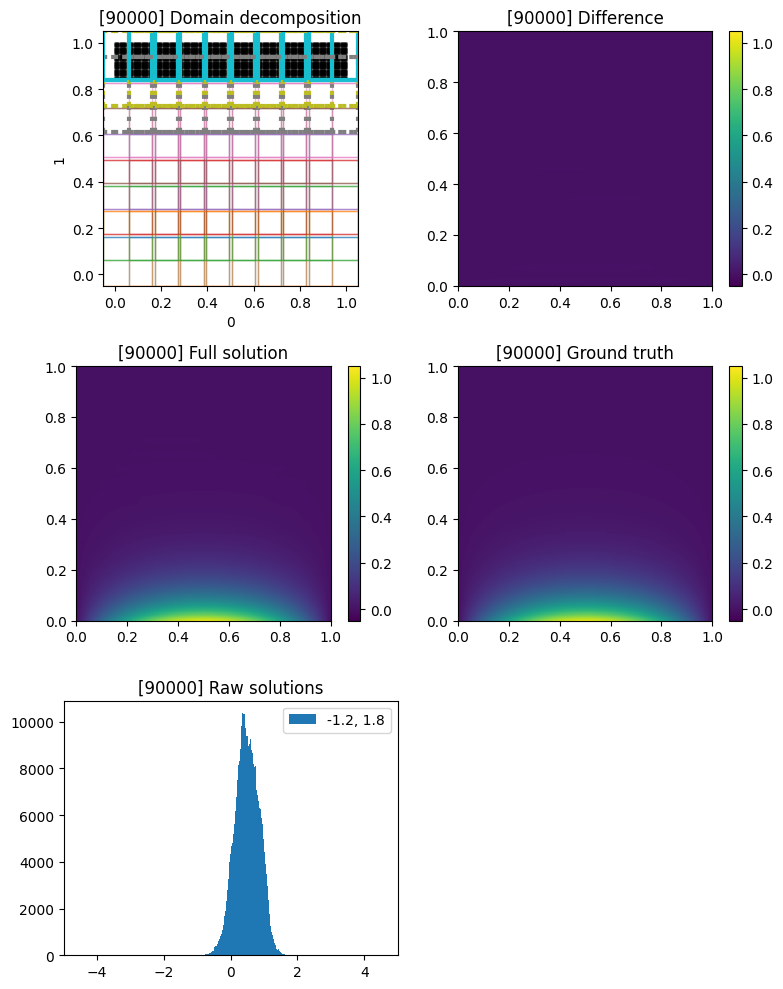

[INFO] 2025-03-26 16:22:07 - saved arrays
[INFO] 2025-03-26 16:22:07 - [i: 91000/100000] loss: 0.0634 rate: 3860.4 elapsed: 0.03 hr test
[INFO] 2025-03-26 16:22:08 - [i: 92000/100000] loss: 0.0199 rate: 3855.9 elapsed: 0.03 hr test
[INFO] 2025-03-26 16:22:08 - [i: 93000/100000] loss: 0.0120 rate: 3865.8 elapsed: 0.03 hr test
[INFO] 2025-03-26 16:22:08 - [i: 94000/100000] loss: 0.0359 rate: 3871.3 elapsed: 0.03 hr test
[INFO] 2025-03-26 16:22:08 - [i: 95000/100000] loss: 0.0159 rate: 3868.0 elapsed: 0.03 hr test
True


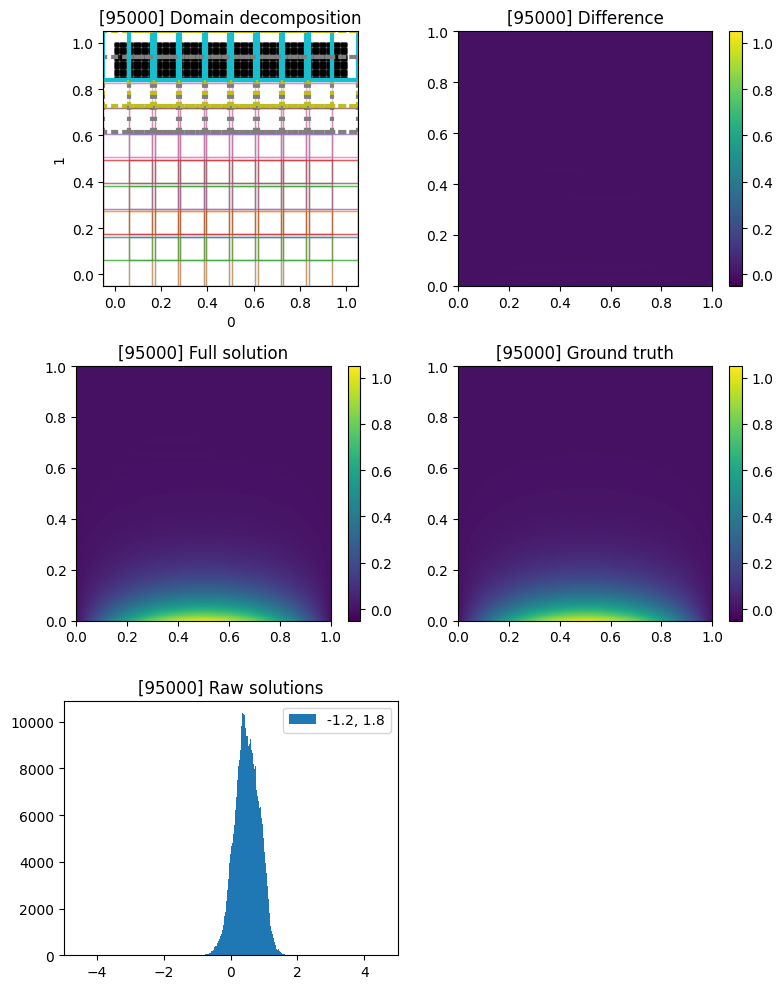

[INFO] 2025-03-26 16:22:09 - saved arrays
[INFO] 2025-03-26 16:22:10 - [i: 96000/100000] loss: 0.0603 rate: 3850.3 elapsed: 0.03 hr test
[INFO] 2025-03-26 16:22:10 - [i: 97000/100000] loss: 0.0122 rate: 3866.4 elapsed: 0.03 hr test
[INFO] 2025-03-26 16:22:10 - [i: 98000/100000] loss: 0.0117 rate: 3866.8 elapsed: 0.03 hr test
[INFO] 2025-03-26 16:22:10 - [i: 99000/100000] loss: 0.0346 rate: 3870.6 elapsed: 0.03 hr test
[INFO] 2025-03-26 16:22:11 - [i: 100000/100000] loss: 0.0193 rate: 3857.0 elapsed: 0.03 hr test
True


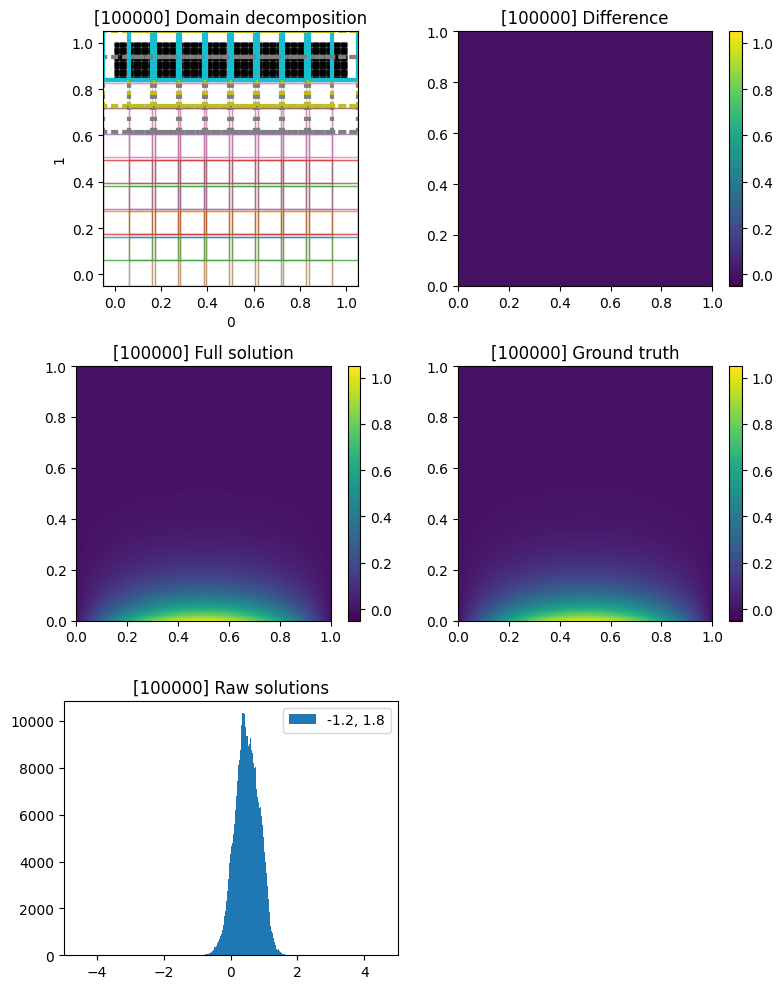

[INFO] 2025-03-26 16:22:11 - saved arrays
[INFO] 2025-03-26 16:22:11 - [i: 100000/100000] Training complete


{'static': {'domain': {'xd': 2,
   'xmin': Array([0., 0.], dtype=float32),
   'xmax': Array([1., 1.], dtype=float32)},
  'problem': {'dims': (1, 2), 'alpha': 1.0},
  'decomposition': {'m': 100,
   'xd': 2,
   'subdomain': {'params': [Array([[-0.16111112, -0.16111112],
            [-0.16111112, -0.05      ],
            [-0.16111112,  0.06111111],
            [-0.16111112,  0.17222223],
            [-0.16111112,  0.28333333],
            [-0.16111112,  0.39444444],
            [-0.16111112,  0.50555557],
            [-0.16111112,  0.6166667 ],
            [-0.16111112,  0.7277778 ],
            [-0.16111112,  0.8388889 ],
            [-0.05      , -0.16111112],
            [-0.05      , -0.05      ],
            [-0.05      ,  0.06111111],
            [-0.05      ,  0.17222223],
            [-0.05      ,  0.28333333],
            [-0.05      ,  0.39444444],
            [-0.05      ,  0.50555557],
            [-0.05      ,  0.6166667 ],
            [-0.05      ,  0.7277778 ],
           

In [2]:
import numpy as np
from fbpinns.domains import RectangularDomainND
from fbpinns.problems import HeatEquation1D  # our newly defined problem
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

# Set the final time for the simulation
T = 1.0
subdomain_xs=[np.linspace(0,1,10), np.linspace(0,1,10)]

# Create a Constants object to hold all hyperparameters
c = Constants(
    # Define the problem domain (x and t)
    domain=RectangularDomainND,
    domain_init_kwargs=dict(
        xmin=np.array([0.0, 0.0]),  # x in [0, 1] and t in [0, T]
        xmax=np.array([1.0, T])
    ),
    # Set the problem to our heat equation
    problem=HeatEquation1D,
    problem_init_kwargs=dict(alpha=1.0),
    # Use a rectangular domain decomposition
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        # Split both x and t into 11 subdomains (you can adjust this as needed)
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0, 1)
    ),
    # Use a fully-connected network; note the input layer size is 2 (x and t)
    # network=FCN,
    # network_init_kwargs=dict(
    #     layer_sizes=(2, 32, 1)
    # ),
    network=ChebyshevKAN,# place a fully-connected network in each subdomain
    network_init_kwargs=dict(
        input_dim=2,
        output_dim=1,
        degree=9
    ),
    scheduler = LineSchedulerRectangularND,
    scheduler_kwargs = dict(
        point=[0.], iaxis=0,
    ),
    # Number of training collocation points and testing points
    # ns=((200,),),
    # n_test=(500,),
    ns=((200,200),),
    n_test=(200,200),
    # Set training steps and optimizer parameters
    n_steps=100000,
    # optimiser_kwargs=dict(learning_rate=1e-3),
    clear_output=False,
)

# Create the trainer and start training
run = FBPINNTrainer(c)
run.train()